## Part 3: Exploratory Data Analysis

**In this notebook,** I explore several aspects of the dataframe and also prepare the dataframe objects for further modeling.

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

## for geospatial
import folium
import geopy


## for machine learning
from sklearn import preprocessing, cluster

#### Importing the saved clean earthquake data, and doing some house-keeping on the dataframe.

In [2]:
file_path = "../datasets/" + "combined_eq_california" + "_timeseries" + ".csv"

#Converting to time-series with respect to "time" column
df_eq = pd.read_csv(file_path, index_col=0)

df_eq["time"] = df_eq.index

df_eq.head(3)

,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth,name,time
time,,,,,,,,,,,,,,,,,
1970-01-02 10:45:20.570,earthquake,3.14,"24km S of Santa Barbara, CA",reviewed,0,152,ci,11.000000,0.234700,0.590000,205.000000,ml,-119.695667,34.206000,6.000000,M: 3.14 / 1970-01-02 / 24km S of Santa Barbar...,1970-01-02 10:45:20.570
1970-01-02 21:47:53.740,earthquake,2.61,"12km NE of Inyokern, CA",reviewed,0,105,ci,6.000000,0.136800,0.730000,96.000000,ml,-117.733667,35.735167,1.650000,"M: 2.61 / 1970-01-02 / 12km NE of Inyokern, CA",1970-01-02 21:47:53.740
1970-01-03 02:51:58.400,earthquake,4.00,"San Francisco Bay area, California",reviewed,0,246,ushis,20.500989,0.198006,0.197771,121.016289,mb,-122.088000,37.298000,6.274206,"M: 4.0 / 1970-01-03 / San Francisco Bay area,...",1970-01-03 02:51:58.400


#### All the column datatypes look fine!

In [3]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313332 entries, 1970-01-02 10:45:20.570 to 2020-10-01 15:28:09.630
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   type       313332 non-null  object 
 1   mag        313332 non-null  float64
 2   place      313332 non-null  object 
 3   status     313332 non-null  object 
 4   tsunami    313332 non-null  int64  
 5   sig        313332 non-null  int64  
 6   net        313332 non-null  object 
 7   nst        313332 non-null  float64
 8   dmin       313332 non-null  float64
 9   rms        313332 non-null  float64
 10  gap        313332 non-null  float64
 11  magType    313329 non-null  object 
 12  longitude  313332 non-null  float64
 13  latitude   313332 non-null  float64
 14  depth      313332 non-null  float64
 15  name       313332 non-null  object 
 16  time       313332 non-null  object 
dtypes: float64(8), int64(2), object(7)
memory usage: 43.0+ MB


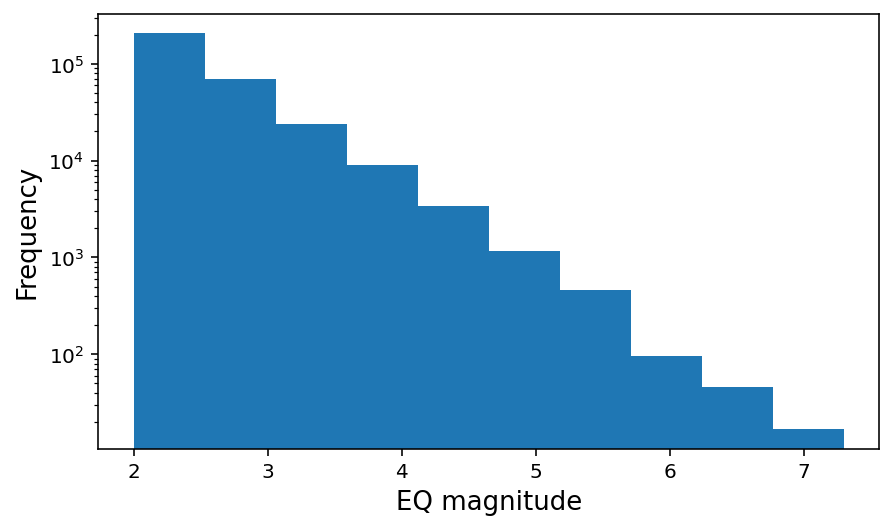

In [4]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = [7, 4])


plt.hist(np.array(df_eq.mag), log=True);
plt.xlabel("EQ magnitude", fontsize = 13);
plt.ylabel("Frequency", fontsize = 13);

#### Figure: The moment magnitude distribution is also shown by histogram. The magnitude distribution closely follows Poisson’s distribution

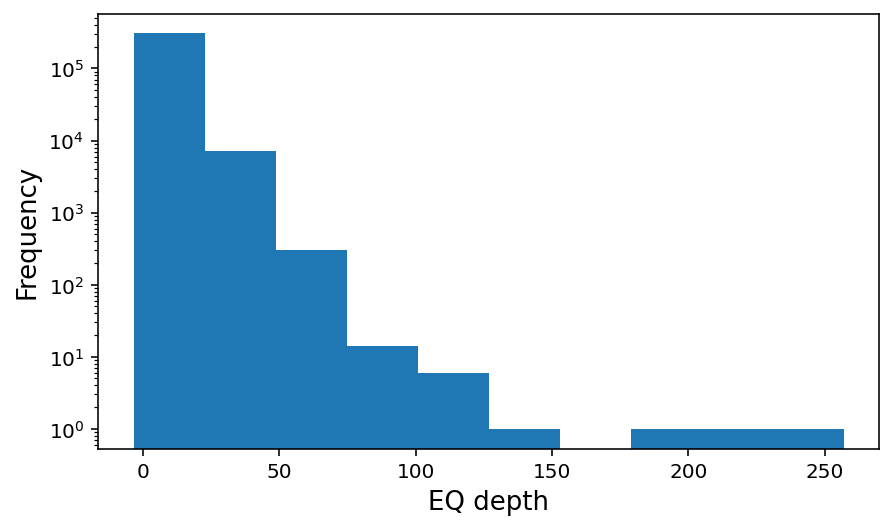

In [5]:
plt.figure(figsize = [7, 4])
plt.hist(np.array(df_eq.depth), log=True);
plt.xlabel("EQ depth", fontsize = 13);
plt.ylabel("Frequency", fontsize = 13);

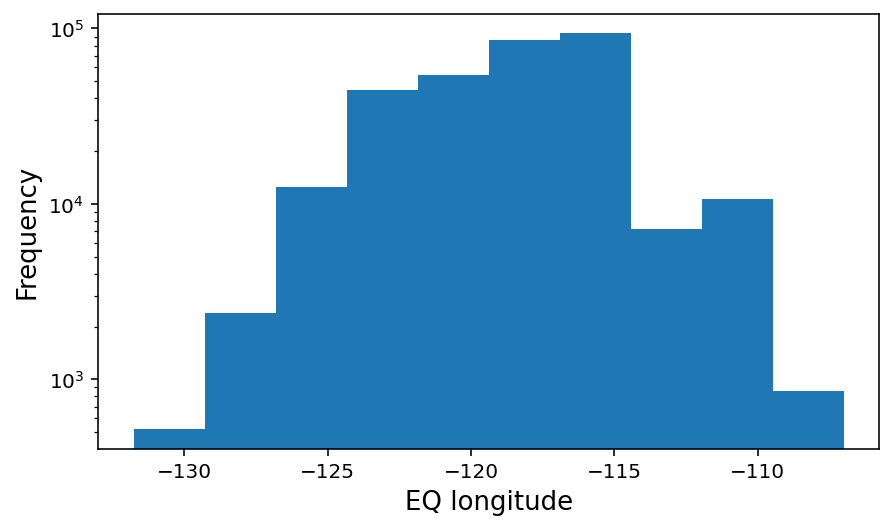

In [6]:
plt.figure(figsize = [7, 4])
plt.hist(np.array(df_eq.longitude), log=True);
plt.xlabel("EQ longitude", fontsize = 13);
plt.ylabel("Frequency", fontsize = 13);

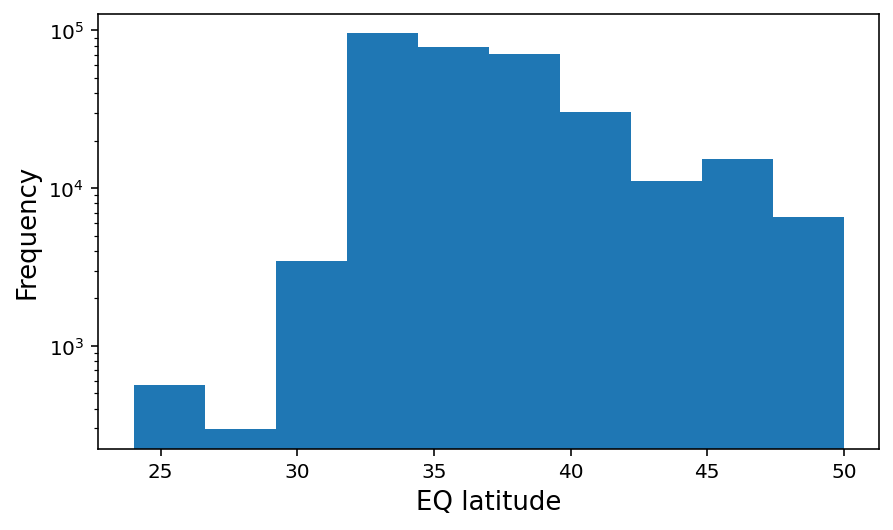

In [7]:
plt.figure(figsize = [7, 4])
plt.hist(np.array(df_eq.latitude), log=True);
plt.xlabel("EQ latitude", fontsize = 13);
plt.ylabel("Frequency", fontsize = 13);

## How many large earthquakes (M>6) happened in last 50 years?

In [8]:
df_eq_large = df_eq[df_eq["mag"]>6].copy()

# Fixing the time column datatype
df_eq_large["time"] = pd.to_datetime(df_eq_large["time"])

df_eq_large["time_diff_day"] = df_eq_large["time"].diff()

df_eq_large.head(5)

,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth,name,time,time_diff_day
time,,,,,,,,,,,,,,,,,,
1971-02-09 14:00:41.920,earthquake,6.6,"10km SSW of Agua Dulce, CA",reviewed,0,1560,ci,0.000000,0.198006,0.249000,123.400000,mw,-118.370,34.416,8.95,"M: 6.6 / 1971-02-09 / 10km SSW of Agua Dulce, CA",1971-02-09 14:00:41.920,NaT
1971-09-30 08:18:00.000,earthquake,6.5,Gulf of California,automatic,0,650,iscgem,20.500989,0.198006,0.197771,121.016289,mw,-110.834,26.816,15.00,M: 6.5 / 1971-09-30 / Gulf of California,1971-09-30 08:18:00.000,232 days 18:17:18.080000
1974-05-31 14:04:59.900,earthquake,6.3,Gulf of California,reviewed,0,611,us,20.500989,0.198006,0.197771,121.016289,ms,-111.238,27.226,33.00,M: 6.3 / 1974-05-31 / Gulf of California,1974-05-31 14:04:59.900,974 days 05:46:59.900000
1975-03-28 02:31:05.700,earthquake,6.1,southern Idaho,reviewed,0,572,us,20.500989,0.198006,0.197771,121.016289,mb,-112.548,42.061,5.00,M: 6.1 / 1975-03-28 / southern Idaho,1975-03-28 02:31:05.700,300 days 12:26:05.800000
1975-07-08 09:37:27.300,earthquake,6.5,"Baja California, Mexico",reviewed,0,650,us,20.500989,0.198006,0.197771,121.016289,ms,-113.346,29.459,33.00,"M: 6.5 / 1975-07-08 / Baja California, Mexico",1975-07-08 09:37:27.300,102 days 07:06:21.600000


In [9]:
df_eq_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1971-02-09 14:00:41.920 to 2020-05-15 11:03:27.176
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   type           85 non-null     object         
 1   mag            85 non-null     float64        
 2   place          85 non-null     object         
 3   status         85 non-null     object         
 4   tsunami        85 non-null     int64          
 5   sig            85 non-null     int64          
 6   net            85 non-null     object         
 7   nst            85 non-null     float64        
 8   dmin           85 non-null     float64        
 9   rms            85 non-null     float64        
 10  gap            85 non-null     float64        
 11  magType        85 non-null     object         
 12  longitude      85 non-null     float64        
 13  latitude       85 non-null     float64        
 14  depth          85 non-

In [10]:
len(df_eq_large)

85

# 85 Large earthquakes (M>6)!

In [11]:
df_eq_large["time_diff_day"].describe()

count                             84
mean     214 days 04:49:19.110190472
std      221 days 14:37:43.431974964
min                  0 days 00:00:18
25%          44 days 19:11:41.638750
50%         150 days 23:23:51.150000
75%         302 days 17:09:17.627500
max        1104 days 13:33:35.280000
Name: time_diff_day, dtype: object

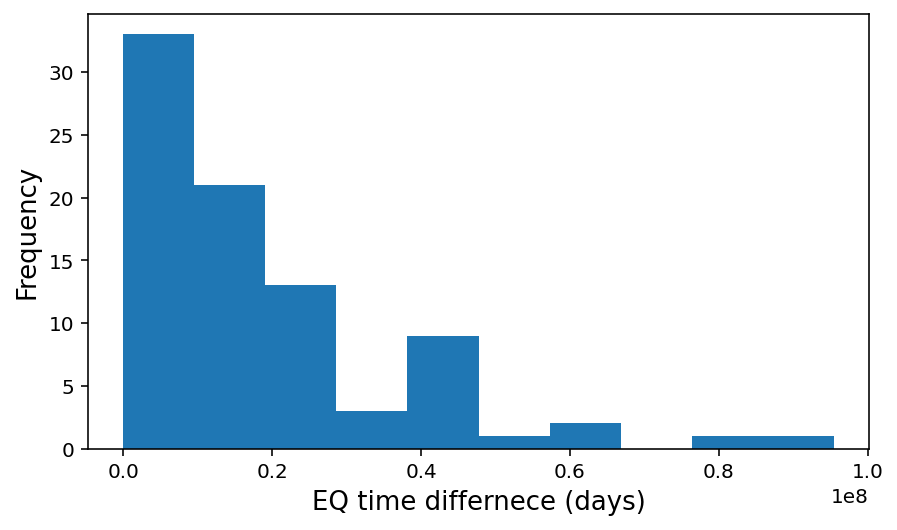

In [12]:
plt.figure(figsize = [7, 4])
df_eq_large["time_diff_day"].astype('timedelta64[s]').plot.hist()

plt.xlabel("EQ time differnece (days)", fontsize = 13);
plt.ylabel("Frequency", fontsize = 13);

Text(0, 0.5, 'Magnitude')

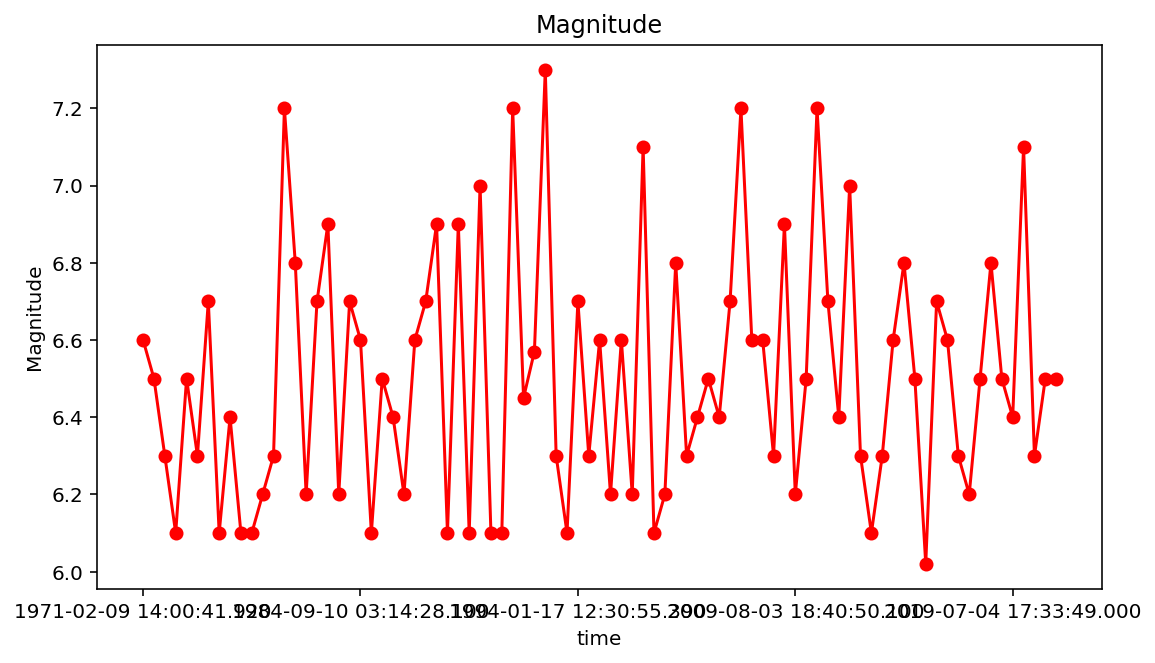

In [13]:
%config InlineBackend.figure_format = 'retina'


# Pandas series with magnitudes greater than 6
plt.figure(figsize=(9,5))
df_eq_large["mag"].plot(style="ro-")

plt.title("Magnitude")
plt.ylabel("Magnitude")

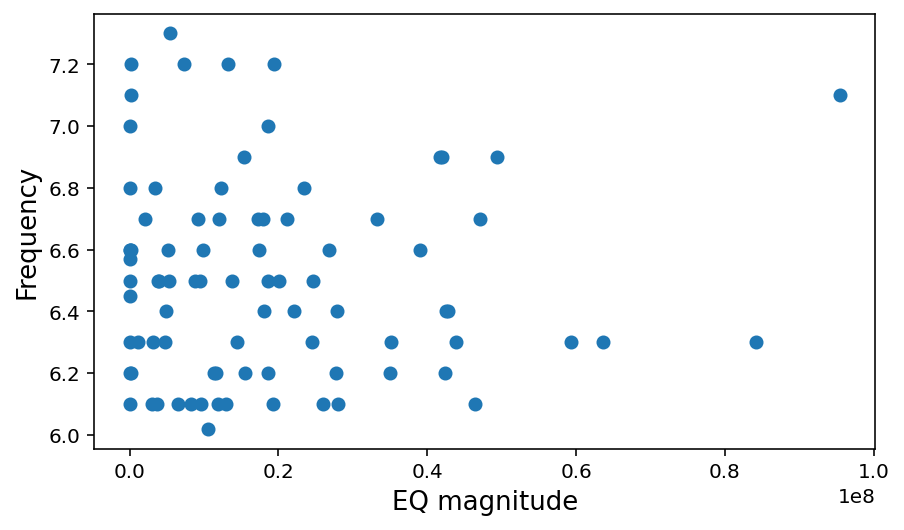

In [14]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = [7, 4])


plt.scatter(df_eq_large["time_diff_day"].astype('timedelta64[s]'),
            df_eq_large.mag)

plt.xlabel("EQ magnitude", fontsize = 13);
plt.ylabel("Frequency", fontsize = 13);

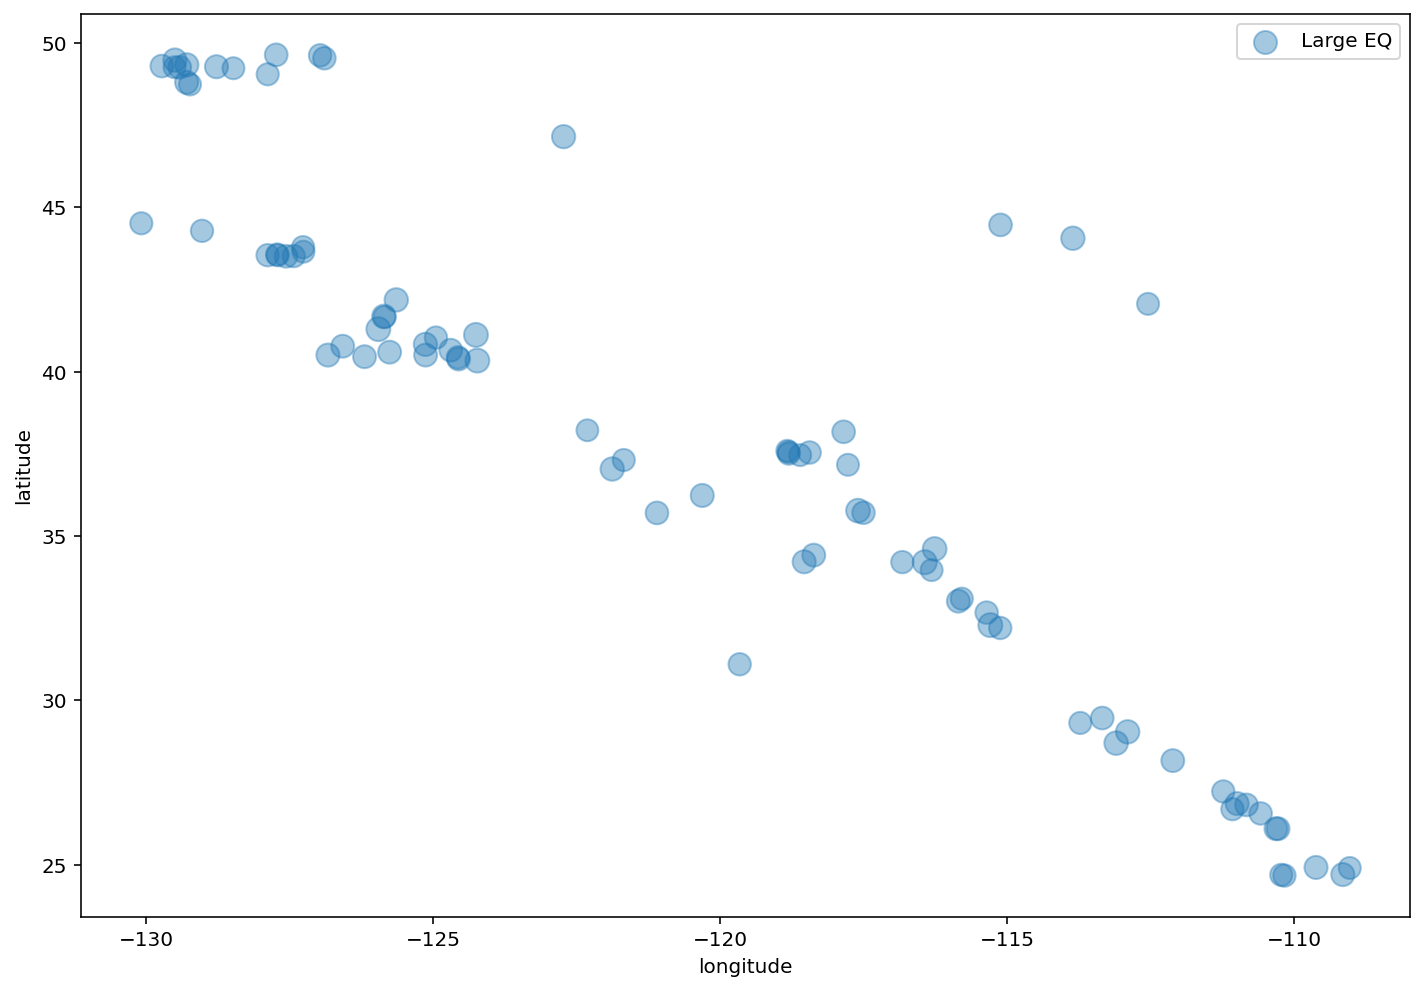

In [15]:
ax = plt.gca()

df_eq_large.plot(kind="scatter", x="longitude", y="latitude",
    s=df_eq_large['mag']/0.05, label="Large EQ",
    alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

# plt.savefig("../plots/EDA_long_lat.png")


plt.tight_layout()

In [16]:
from mpl_toolkits.basemap import Basemap

In [17]:
type(list(pd.to_datetime(df_eq_large.index))[0].date())

datetime.date

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


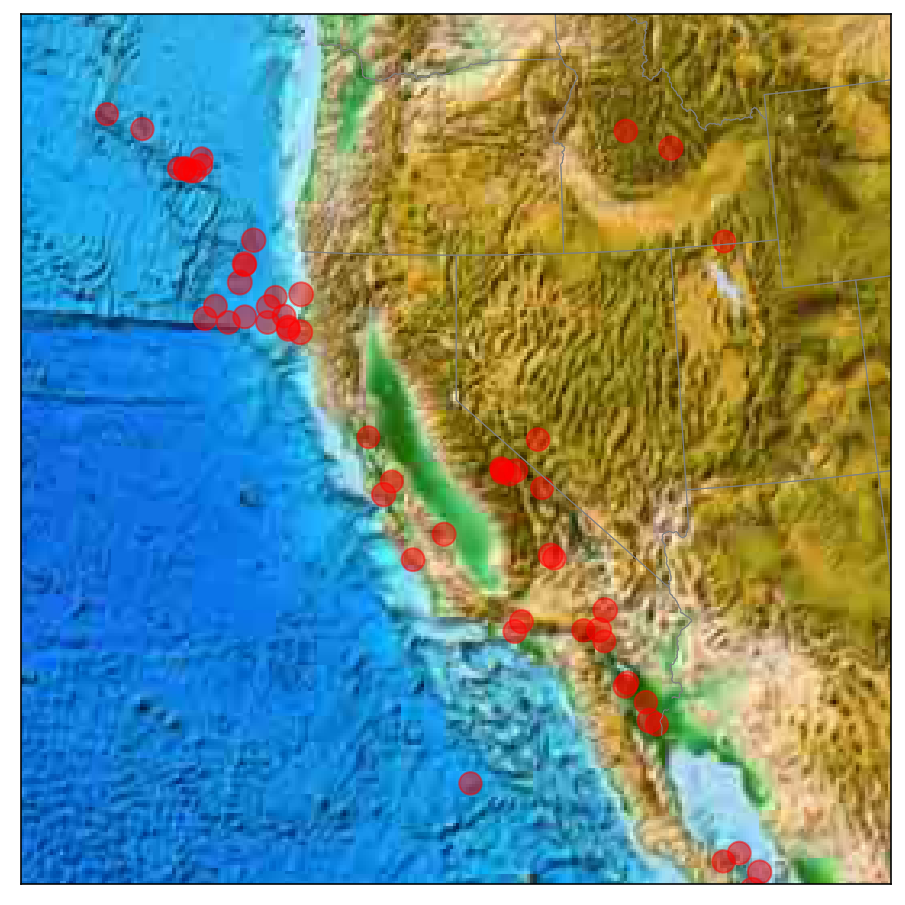

In [18]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=38, lon_0=-120,
            width=2.0E6, height=2.0E6)

# m.bluemarble()
m.etopo()


# m.drawcoastlines(color='blue',linewidth=3)
# m.drawcountries(color='gray',linewidth=3)
m.drawstates(color='gray')


lon = list(df_eq_large["longitude"])
lat = list(df_eq_large["latitude"])

m.scatter(lon,lat, latlon=True,
#           c=color,
          s=df_eq_large['mag']/0.05,
          c = 'red',
#           cmap='YlGnBu_r',
          alpha=0.5)

# df_eq_large.plot(kind="scatter", x="longitude", y="latitude",
#     s=df_eq_large['mag']/0.05, label="Large EQ",
#     alpha=0.4, figsize=(10,7), ax = ax
# )


In [19]:
# Source: https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

city = "California"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

x, y = "latitude", "longitude"
color = "time"
size = "mag"
popup = "name"
data = df_eq_large.copy()

## create color column
lst_colors=["black"]
data["color"] = "black"
lst_elements = sorted(list(data["color"].unique()))

## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)




## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=7)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_

California, United States
[lat, long]: [36.7014631, -118.7559974]


#### Figure: most large EQ's were along the coast

## What happened 30 days ahead of 1989 Loma Prieta earthquake ?

In [20]:
df_eq_lp = df_eq['1989-09-19':'1989-10-19']

df_eq_lp.head()

,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth,name,time
time,,,,,,,,,,,,,,,,,
1989-09-19 02:49:47.290,earthquake,2.30,"17km E of Desert Hot Springs, CA",reviewed,0,81,ci,0.000000,0.198006,0.054,70.000000,mc,-116.316,33.971,7.935,M: 2.3 / 1989-09-19 / 17km E of Desert Hot Sp...,1989-09-19 02:49:47.290
1989-09-19 03:03:33.230,earthquake,2.79,"12km ESE of Anza, CA",reviewed,0,120,ci,0.000000,0.198006,0.109,39.800000,ml,-116.557,33.517,12.388,"M: 2.79 / 1989-09-19 / 12km ESE of Anza, CA",1989-09-19 03:03:33.230
1989-09-19 09:46:00.790,earthquake,3.70,Arizona,reviewed,0,211,us,20.500989,0.198006,0.700,121.016289,ml,-112.407,36.663,5.000,M: 3.7 / 1989-09-19 / Arizona,1989-09-19 09:46:00.790
1989-09-19 16:29:32.540,earthquake,2.25,"15km S of Las Flores, CA",reviewed,0,78,ci,0.000000,0.198006,0.132,126.900000,mc,-118.616,33.902,11.117,"M: 2.25 / 1989-09-19 / 15km S of Las Flores, CA",1989-09-19 16:29:32.540
1989-09-19 17:46:55.920,earthquake,2.61,"48km ENE of San Clemente Is. (SE tip), CA",reviewed,0,105,ci,0.000000,0.198006,0.241,199.700000,mc,-117.909,33.040,5.633,M: 2.61 / 1989-09-19 / 48km ENE of San Clemen...,1989-09-19 17:46:55.920


/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


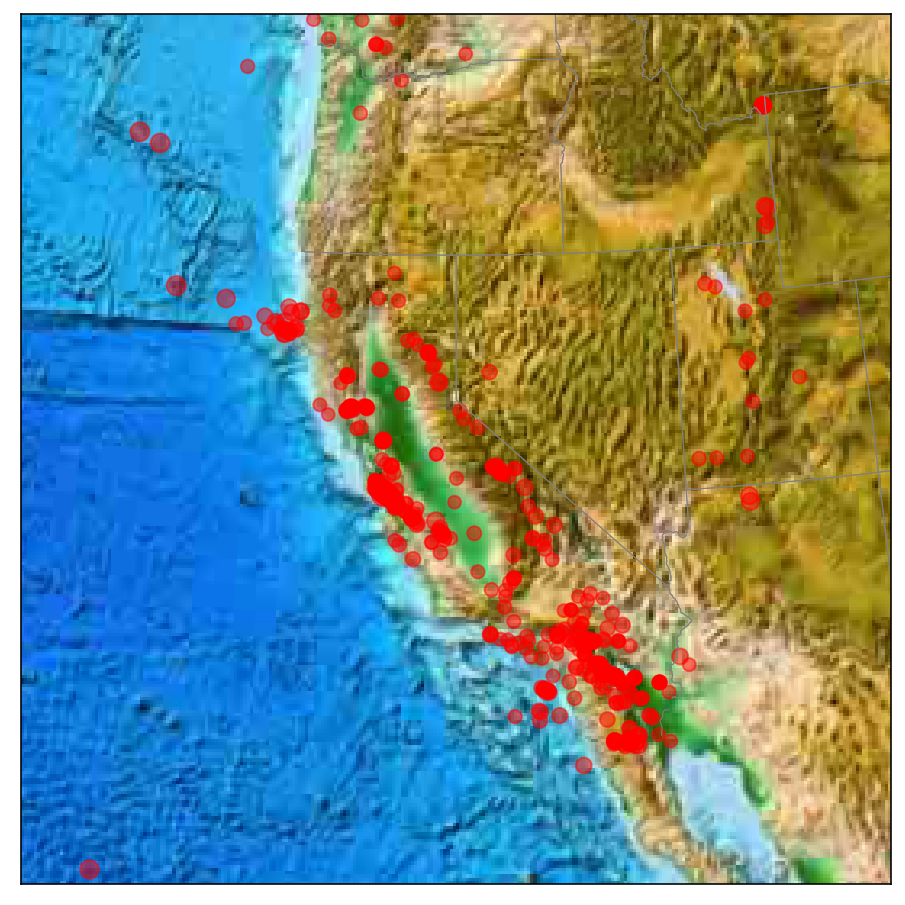

In [21]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=38, lon_0=-120,
            width=2.0E6, height=2.0E6)

# m.bluemarble()
m.etopo()


# m.drawcoastlines(color='blue',linewidth=3)
# m.drawcountries(color='gray',linewidth=3)
m.drawstates(color='gray')


lon = list(df_eq_lp["longitude"])
lat = list(df_eq_lp["latitude"])

m.scatter(lon,lat, latlon=True,
#           c=color,
          s=df_eq_lp['mag']/0.05,
          c = 'red',
#           cmap='YlGnBu_r',
          alpha=0.5)

# df_eq_large.plot(kind="scatter", x="longitude", y="latitude",
#     s=df_eq_large['mag']/0.05, label="Large EQ",
#     alpha=0.4, figsize=(10,7), ax = ax
# )



In [22]:
# Source: https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

city = "California"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

x, y = "latitude", "longitude"
color = "time"
size = "mag"
popup = "name"
data = df_eq_lp.copy()

## create color column
lst_colors=["black"]
data["color"] = "black"
lst_elements = sorted(list(data["color"].unique()))

## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)




## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=7)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_

California, United States
[lat, long]: [36.7014631, -118.7559974]


Text(0, 0.5, 'Magnitude')

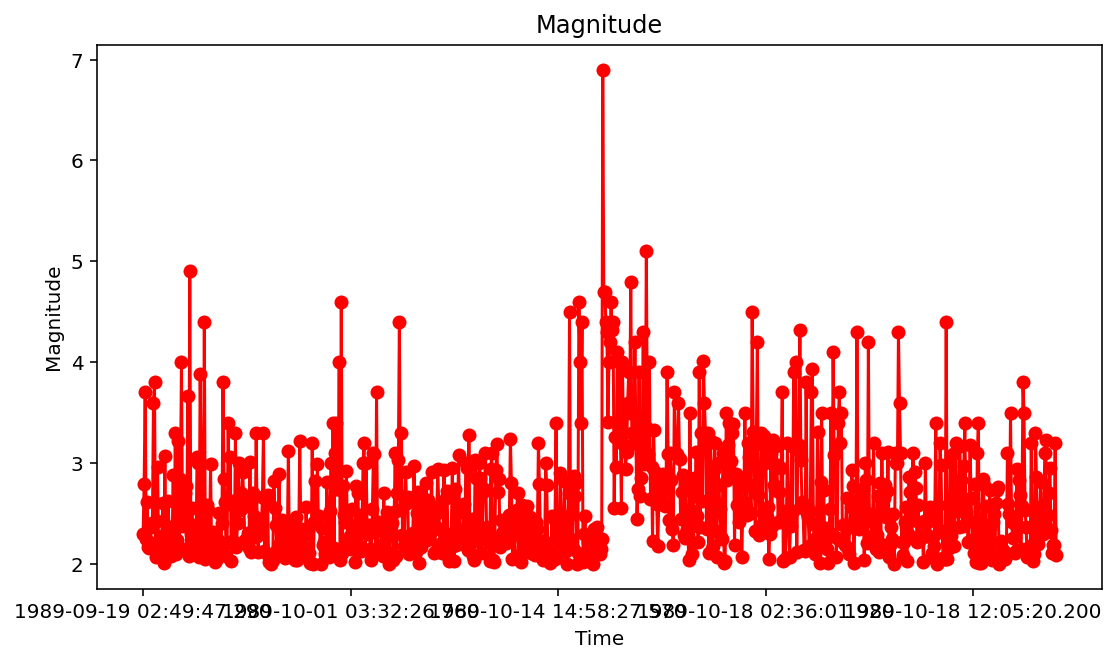

In [23]:
%config InlineBackend.figure_format = 'retina'


# Pandas series with magnitudes greater than 6
plt.figure(figsize=(9,5))
df_eq_lp["mag"].plot(style="ro-")

plt.title("Magnitude")
plt.xlabel('Time')
plt.ylabel("Magnitude")

Figure suggests that the main shock, which had magnitude of 7 was just a spike in magnitude domain!

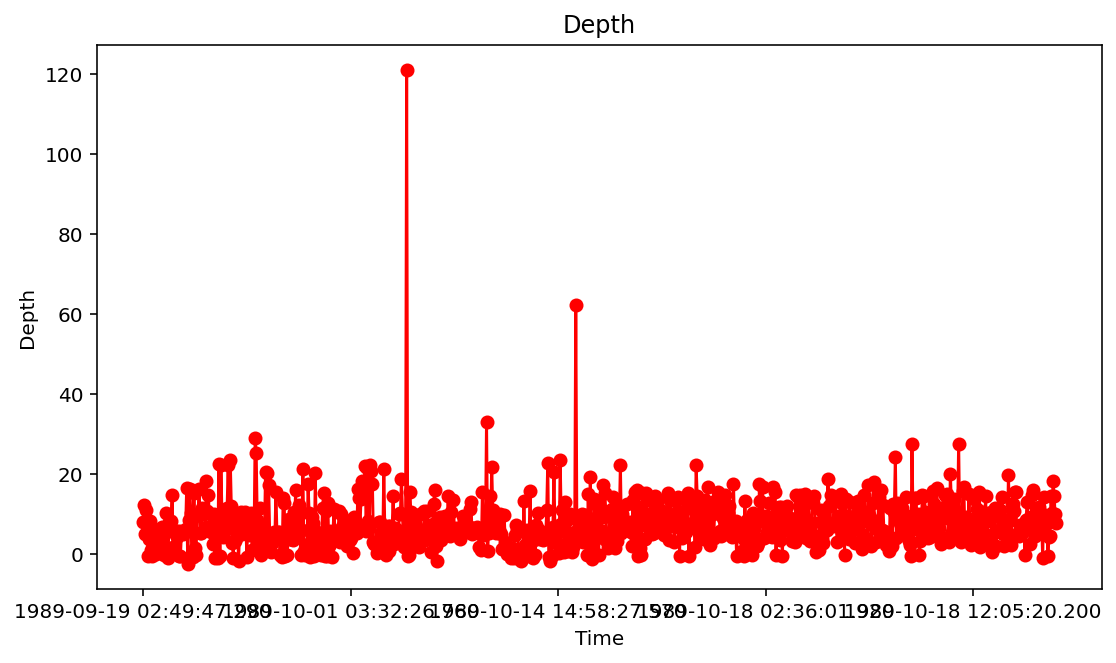

In [24]:
%config InlineBackend.figure_format = 'retina'


# Pandas series with magnitudes greater than 6
plt.figure(figsize=(9,5))
df_eq_lp["depth"].plot(style="ro-")

plt.title("Depth")
plt.xlabel('Time')
plt.ylabel("Depth");

Same goes for depth!

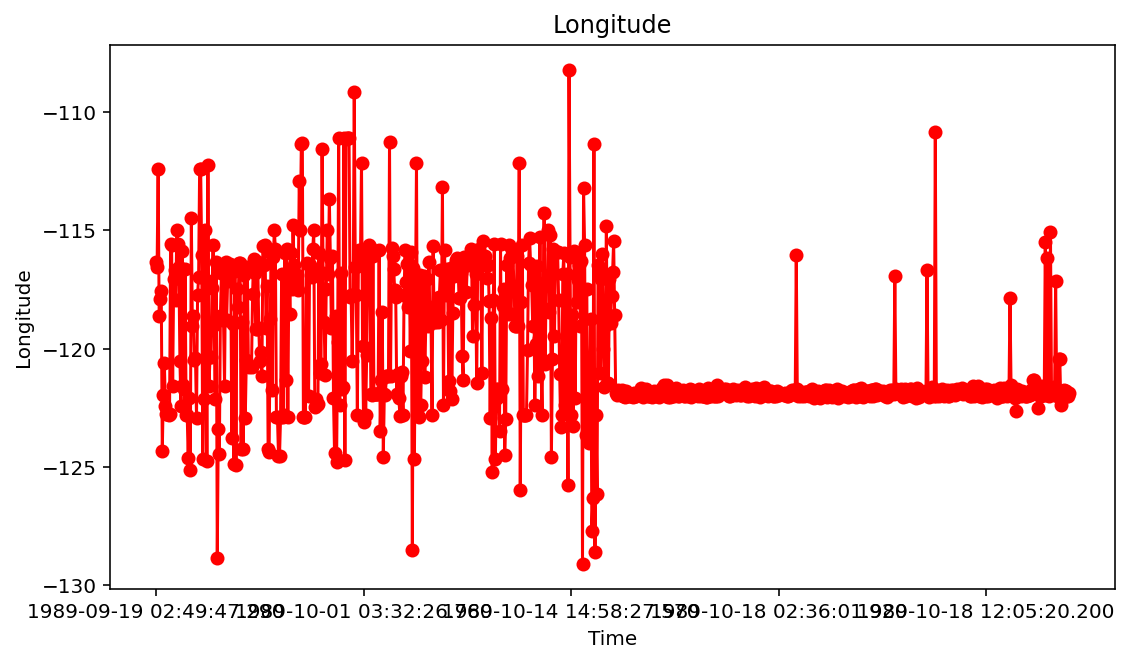

In [25]:
%config InlineBackend.figure_format = 'retina'


# Pandas series with magnitudes greater than 6
plt.figure(figsize=(9,5))
df_eq_lp["longitude"].plot(style="ro-")

plt.title("Longitude")
plt.xlabel('Time')
plt.ylabel("Longitude");

Same goes for Longitude!

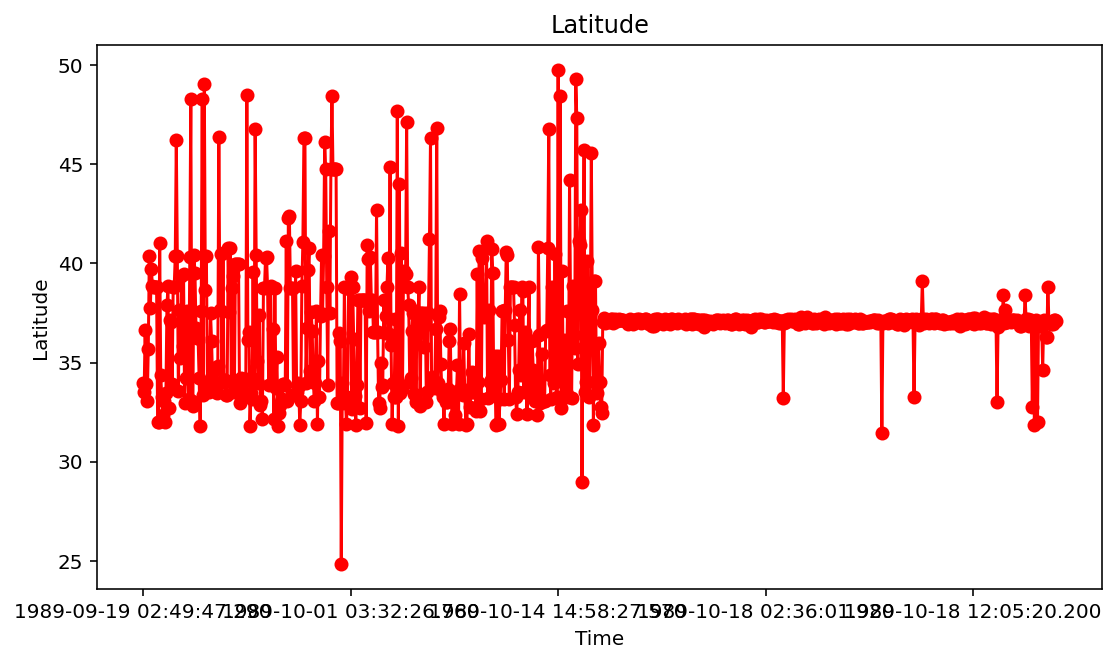

In [26]:
%config InlineBackend.figure_format = 'retina'


# Pandas series with magnitudes greater than 6
plt.figure(figsize=(9,5))
df_eq_lp["latitude"].plot(style="ro-")

plt.title("Latitude")
plt.xlabel('Time')
plt.ylabel("Latitude");

Same goes for depth!

In addition to the main fault activites, there was a parallel fault (presumably) active as well!

In addition to the main fault activites, there was a parallel fault (presumably) active as well!

### Now, looking at tempral earthquake focus points

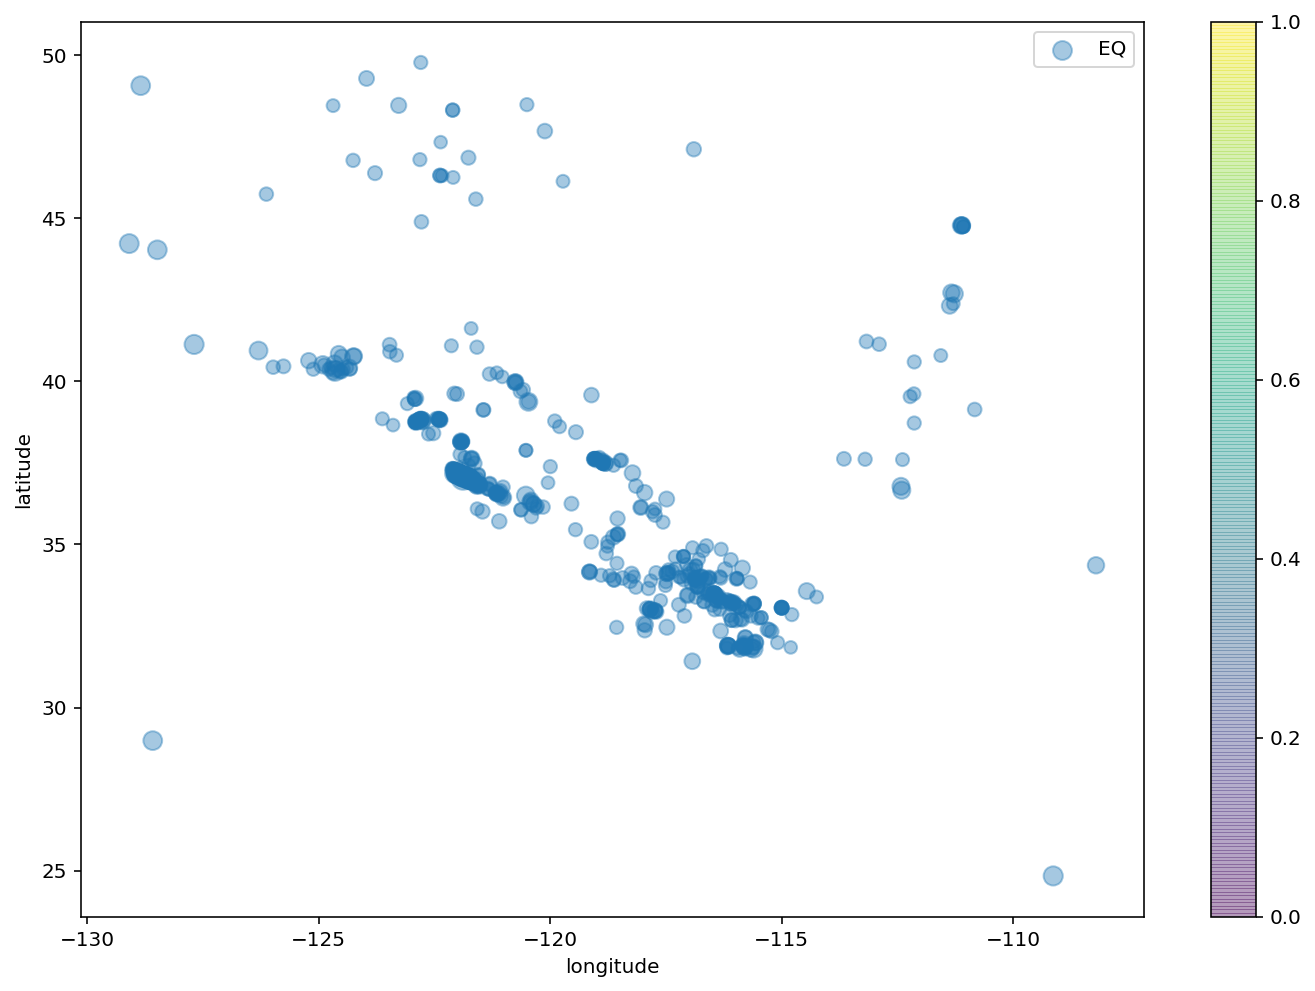

In [27]:
ax = plt.gca()

df_eq_lp.plot(kind="scatter", x="longitude", y="latitude",
    s=df_eq_lp['mag']/0.05, label="EQ",
#     c=df_eq_lp.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

# plt.savefig("../plots/EDA_long_lat.png")


plt.tight_layout()

### What happens to EQ cycle every one hour ?

In [28]:
print("Hello World!")

Hello World!
